<a href="https://colab.research.google.com/github/kimkat27/LE1_Tripulca_K/blob/main/Slump_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SlumpTest using Linear Regression**

This is all about Concrete slump test that has 10 features and 103 instances.

***Additional Information***
The data set includes 103 data points. There are 7 input variables, and 3 output variables in the data set. The initial data set included 78 data. After several years, we got 25 new data points.

Concrete is a highly complex material. The slump flow of concrete is not only determined by the water content, but that is also influenced by other concrete ingredients.

In [2]:
# Importing necessary libraries
import pandas as pd # for us to display our dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import copy
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [10]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/LE1_Tripulca_K/dataset/slump_test.csv')

# Display dataset information
print(df)

      No  Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  \
0      1   273.0   82.0    105.0  210.0   9.0         904.0       680.0   
1      2   163.0  149.0    191.0  180.0  12.0         843.0       746.0   
2      3   162.0  148.0    191.0  179.0  16.0         840.0       743.0   
3      4   162.0  148.0    190.0  179.0  19.0         838.0       741.0   
4      5   154.0  112.0    144.0  220.0  10.0         923.0       658.0   
..   ...     ...    ...      ...    ...   ...           ...         ...   
98    99   248.3  101.0    239.1  168.9   7.7         954.2       640.6   
99   100   248.0  101.0    239.9  169.1   7.7         949.9       644.1   
100  101   258.8   88.0    239.6  175.3   7.6         938.9       646.0   
101  102   297.1   40.9    239.9  194.0   7.5         908.9       651.8   
102  103   348.7    0.1    223.1  208.5   9.6         786.2       758.1   

     SLUMP(cm)  FLOW(cm)  Compressive Strength (28-day)(Mpa)  
0         23.0      62.0            

In [12]:
# Data Cleaning
# Check for missing values and duplicates
print(df.isnull().sum())
print(df.duplicated().sum())

No                                    0
Cement                                0
Slag                                  0
Fly ash                               0
Water                                 0
SP                                    0
Coarse Aggr.                          0
Fine Aggr.                            0
SLUMP(cm)                             0
FLOW(cm)                              0
Compressive Strength (28-day)(Mpa)    0
dtype: int64
0


In [13]:
# Check if the 'No' column exists before dropping it
if 'No' in df.columns:
    df.drop('No', axis=1, inplace=True)

In [14]:
# After cleaning and outlier treatment of dataset named df
df.to_csv('/content/drive/MyDrive/LE1_Tripulca_K/dataset/cleaned_dataset.csv', index=False)

# Make a copy of the cleaned dataset
cleaned_dataset = df.copy()
print (cleaned_dataset)

     Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
0     273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
1     163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
2     162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
3     162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
4     154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   
..      ...    ...      ...    ...   ...           ...         ...        ...   
98    248.3  101.0    239.1  168.9   7.7         954.2       640.6        0.0   
99    248.0  101.0    239.9  169.1   7.7         949.9       644.1        2.0   
100   258.8   88.0    239.6  175.3   7.6         938.9       646.0        0.0   
101   297.1   40.9    239.9  194.0   7.5         908.9       651.8       27.5   
102   348.7    0.1    223.1  208.5   9.6         786.2       758.1       29.0   

     FLOW(cm)  Compressive 

Graphical Analysis

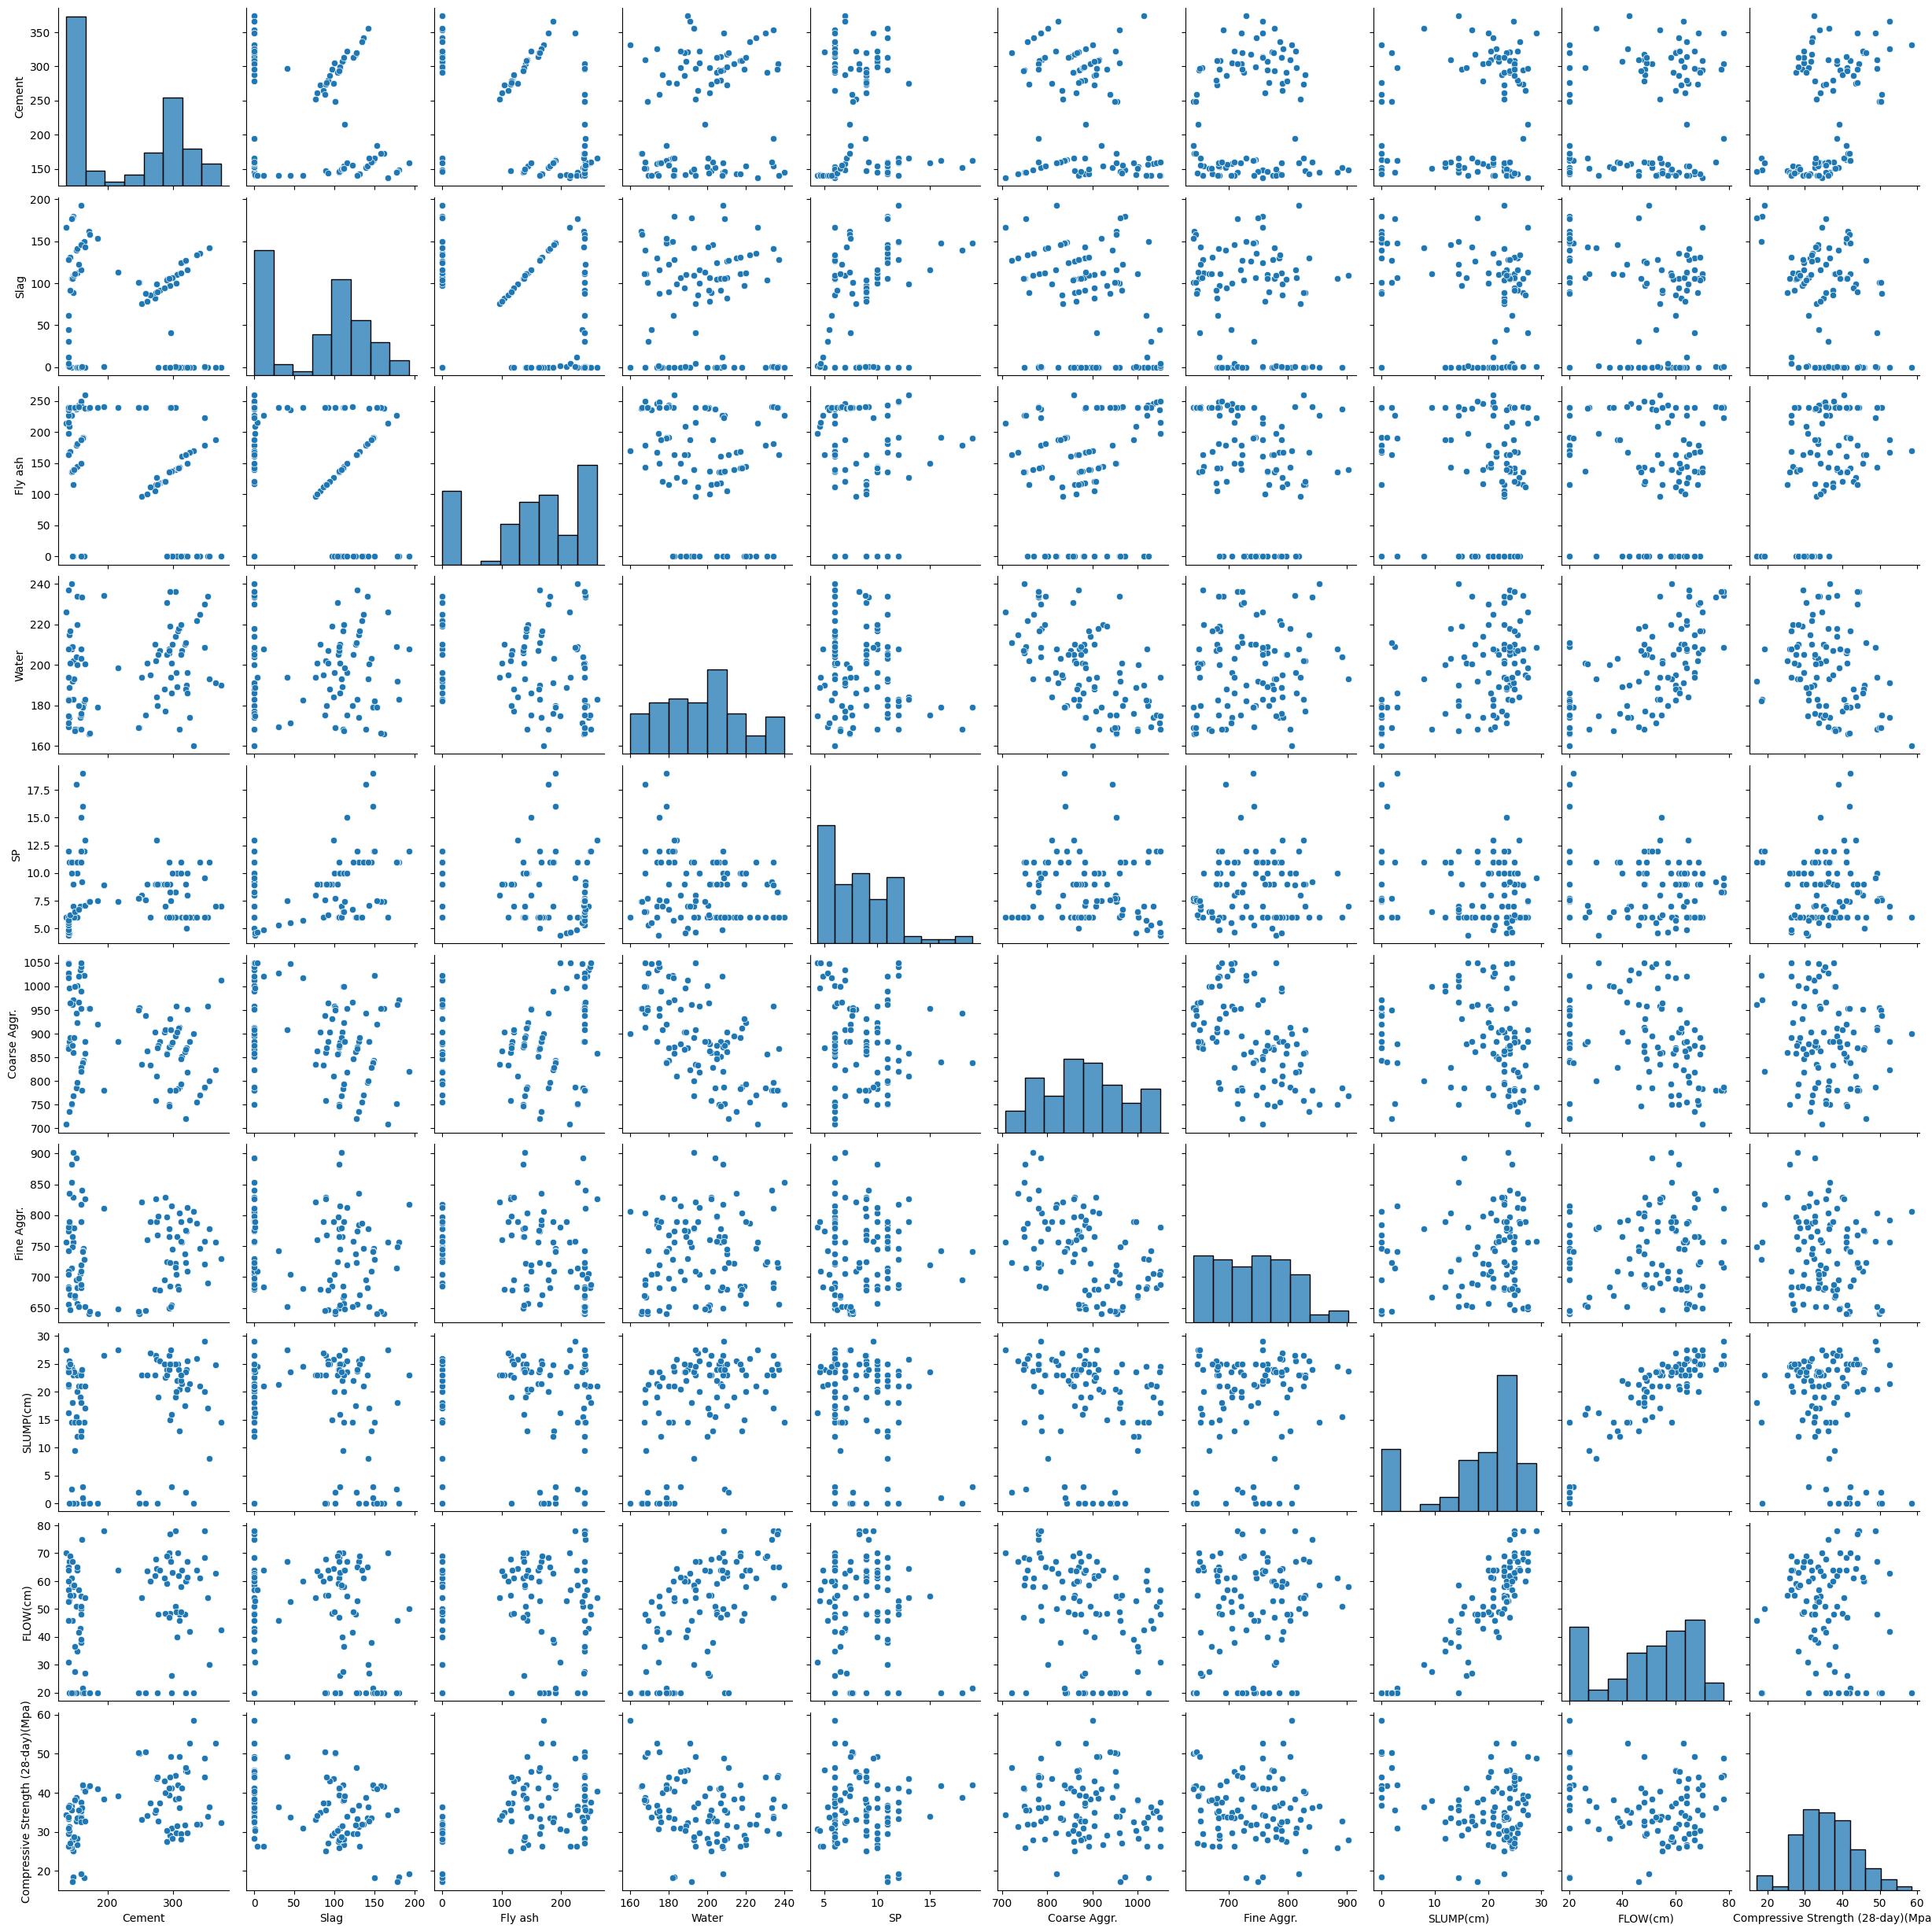

In [15]:
# EDA
# Visualize data distribution and relationships
sns.pairplot(cleaned_dataset)
plt.show()

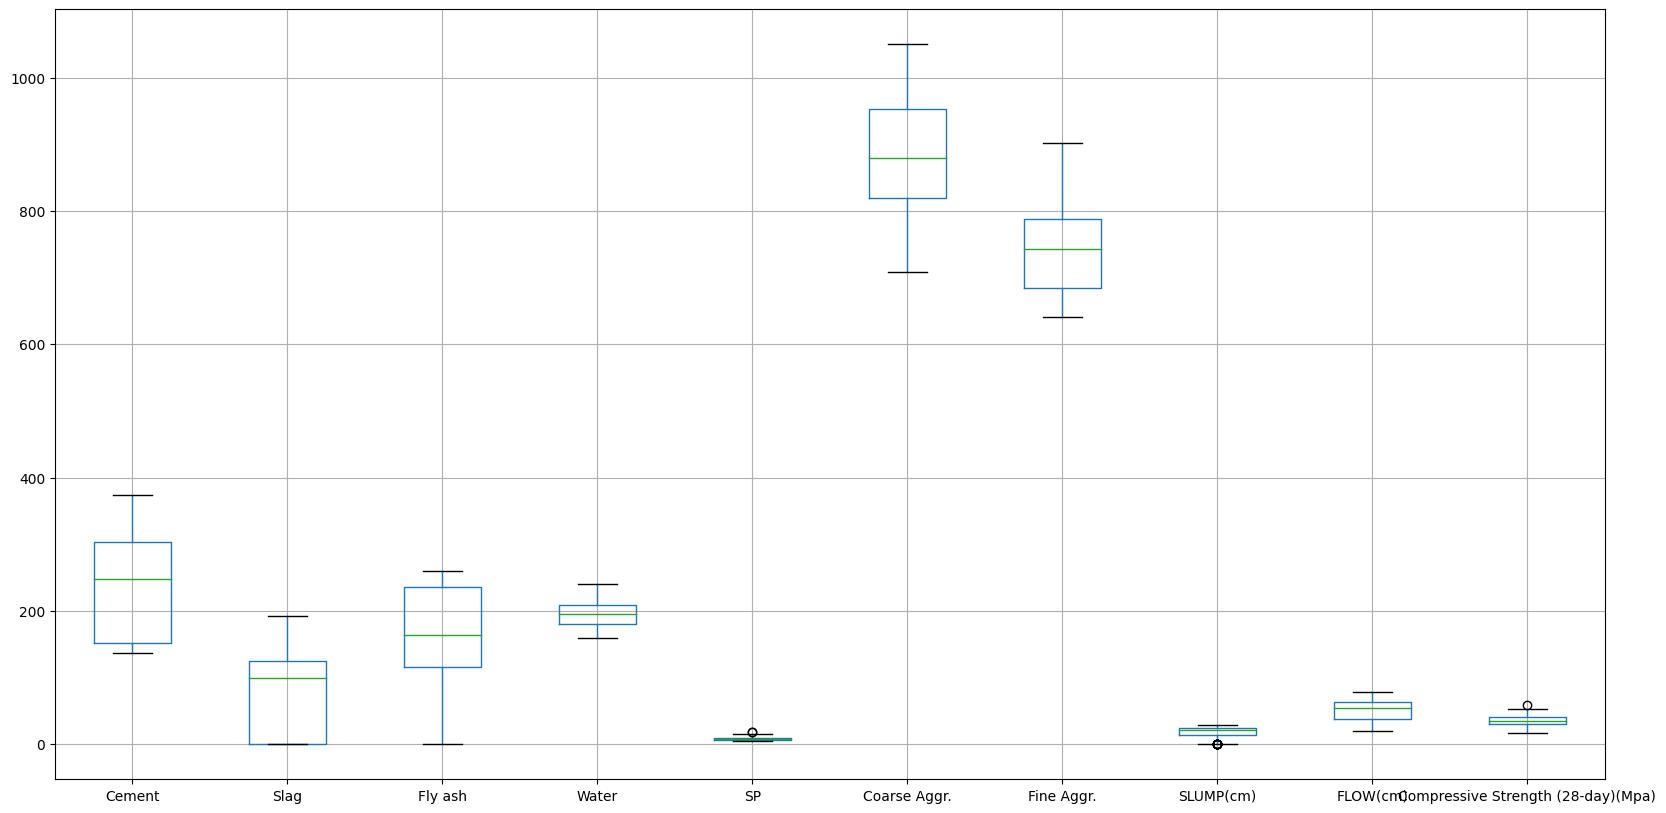

In [16]:
#checking outliers
plt.figure(figsize = (20,10))
cleaned_dataset.boxplot();

In [17]:
def handle_outliers(cleaned_dataset, columns):
    for column in columns:
        q1 = cleaned_dataset[column].quantile(0.25)
        q3 = cleaned_dataset[column].quantile(0.75)
        iqr = q3 - q1
        lower_threshold = q1 - 1.5 * iqr
        upper_threshold = q3 + 1.5 * iqr
        cleaned_dataset[column] = np.where(cleaned_dataset[column] < lower_threshold, lower_threshold, cleaned_dataset[column])
        cleaned_dataset[column] = np.where(cleaned_dataset[column] > upper_threshold, upper_threshold, cleaned_dataset[column])
    return cleaned_dataset

# Define the list of columns containing outliers
outlier_columns = ['SP', 'SLUMP(cm)', 'Compressive Strength (28-day)(Mpa)']

# Call the handle_outliers function with both the DataFrame and the list of columns
cleaned_dataset = handle_outliers(df, outlier_columns)

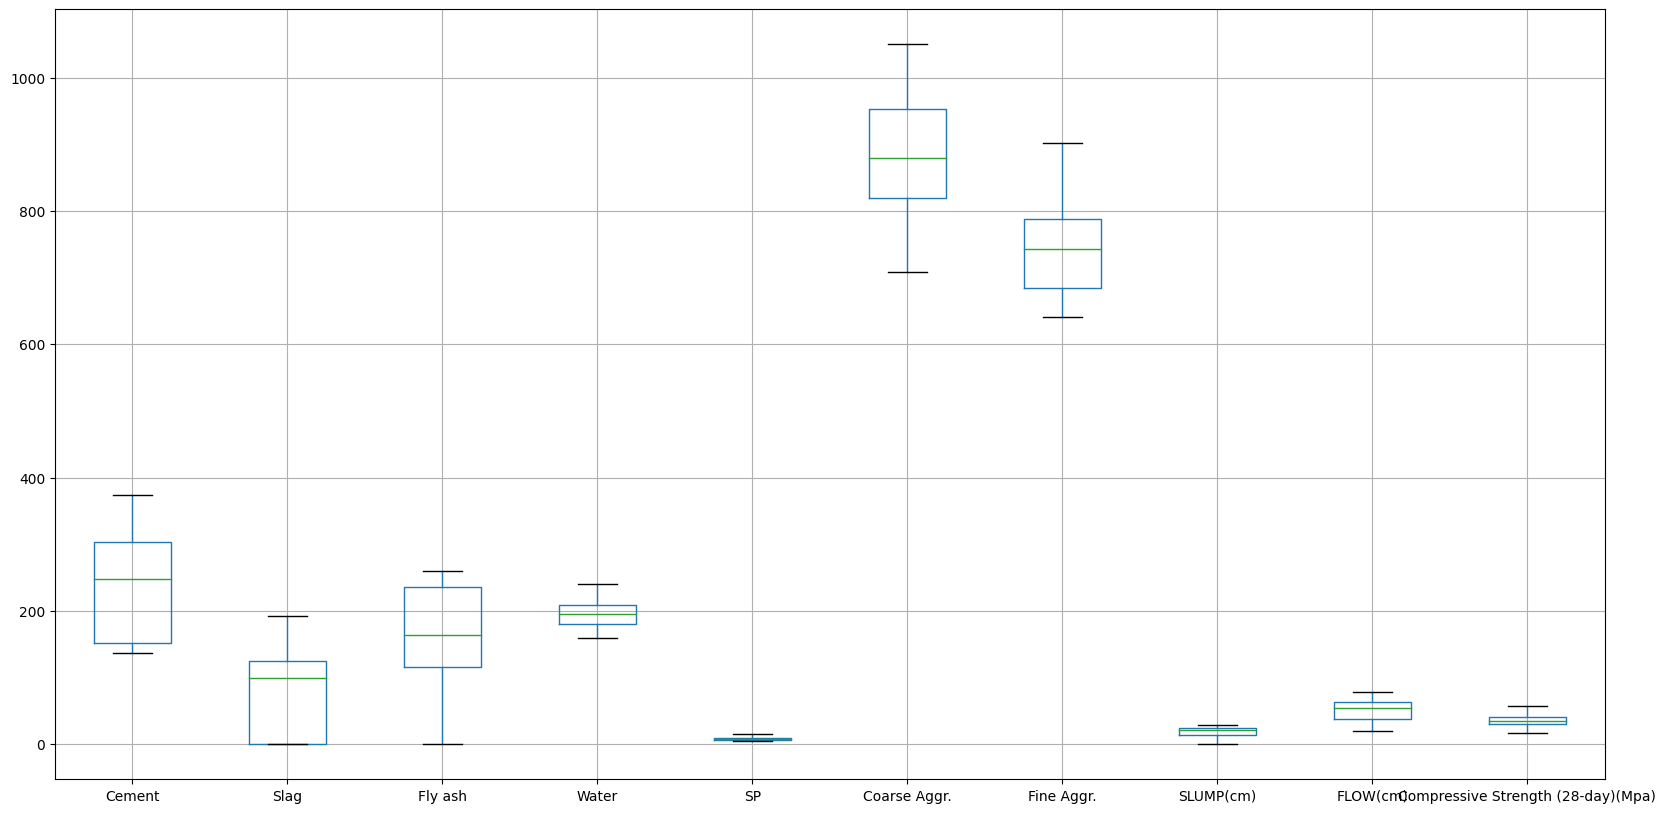

In [18]:
#Checking after handling outliers
plt.figure(figsize = (20,10))
cleaned_dataset.boxplot();

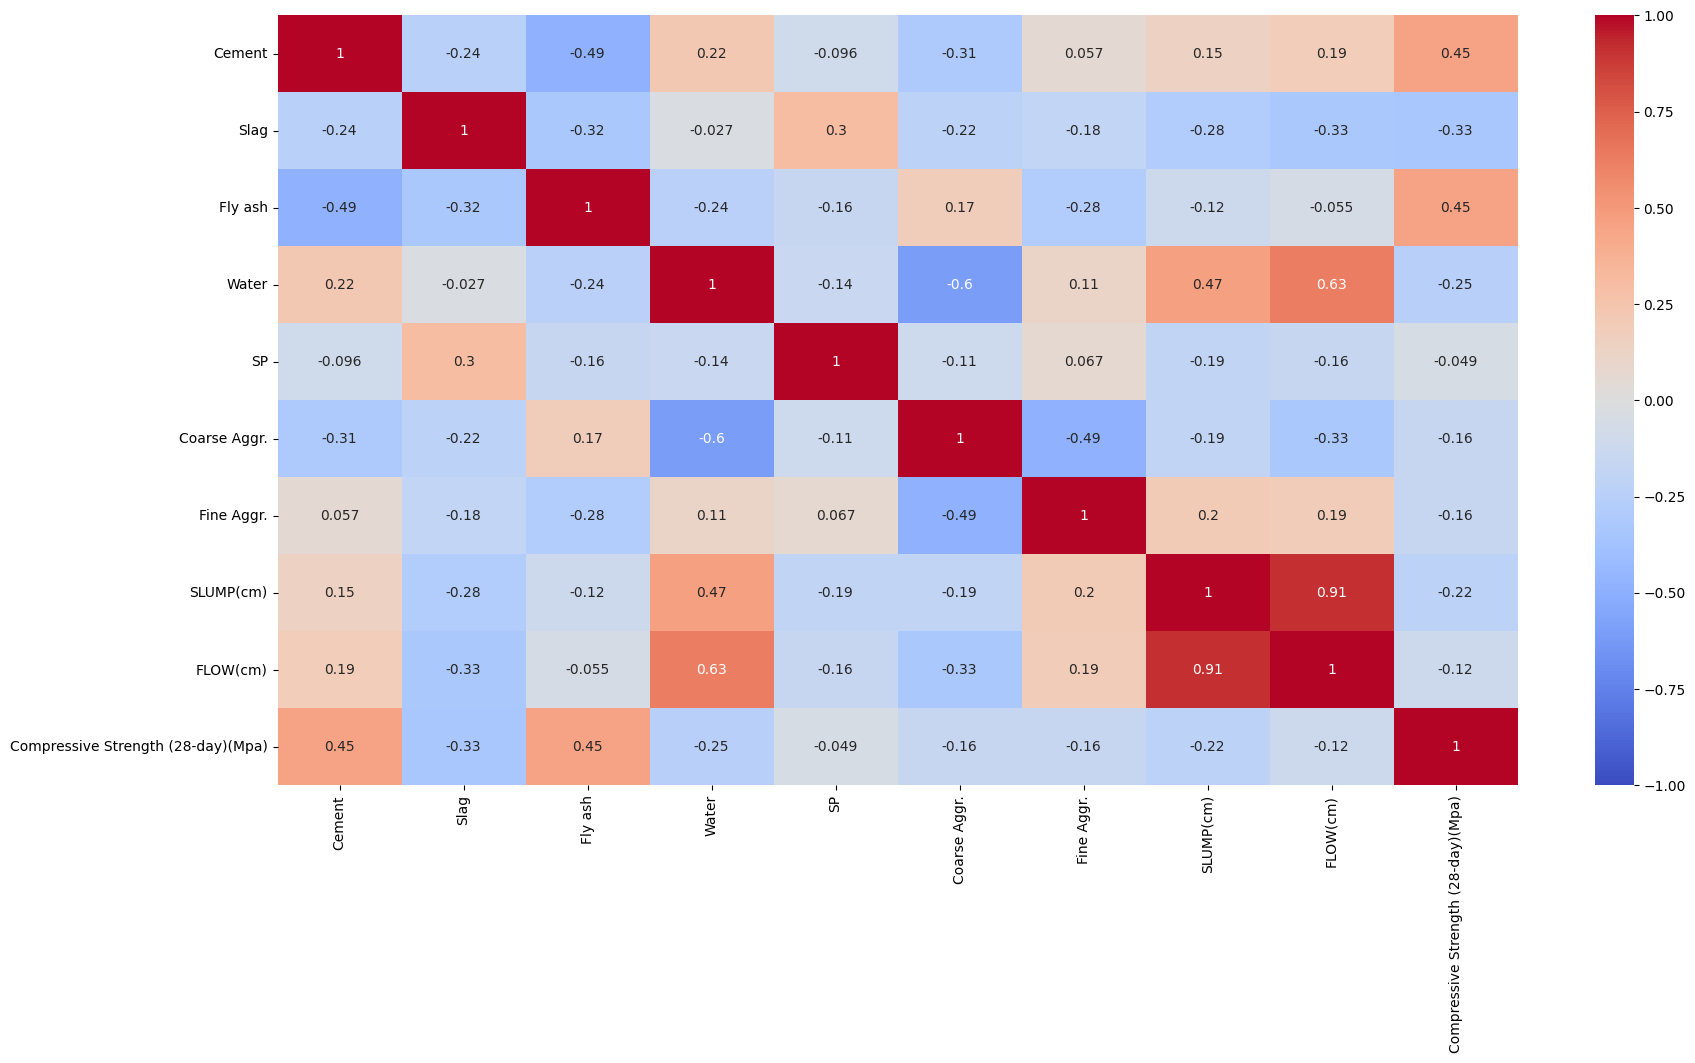

In [19]:
#checking multicollinearity
correlation_matrix = cleaned_dataset.corr(numeric_only=True)

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

It can be observed that the highest correlations with the target feature are in the "Cement" and "Fly ash" columns, while the lowest correlation is with the "Flow (cm)" column. Additionally, in this table, we can infer that the features "Slump" and "Flow" with a correlation of 0.9 exhibit multicollinearity.

In [21]:
# Data Splitting
X = cleaned_dataset.drop("Compressive Strength (28-day)(Mpa)", axis=1)
y = cleaned_dataset["Compressive Strength (28-day)(Mpa)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#Handling multicollinearity by selecting best features based on importance

# Define your regression model (e.g., Linear Regression or Random Forest Regressor)
model = LinearRegression()

# Fit the model to your data
model.fit(X_train, y_train)

# Evaluate feature importance (if applicable to the model)
if hasattr(model, 'coef_'):
    feature_importance = model.coef_
else:
    # For tree-based models, use feature_importances_
    feature_importance = model.feature_importances_

# Select features based on importance
selector = SelectFromModel(model, threshold='mean')
selector.fit(X_train, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get names of selected features
selected_features = X_train.columns[selected_feature_indices]

# Print selected features
print("Selected Features based on importance:")
print(selected_features)

Selected Features based on importance:
Index(['Water', 'SLUMP(cm)'], dtype='object')


In [23]:
# Data Leakage Prevention
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8
count,8.200000e+01,82.000000,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01
mean,2.978647e-17,0.000000,1.218537e-16,-6.539484e-16,-6.228080e-17,4.088870e-16,2.349069e-16,-1.218537e-16,-2.437075e-17
std,1.006154e+00,1.006154,1.006154e+00,1.006154e+00,1.006154e+00,1.006154e+00,1.006154e+00,1.006154e+00,1.006154e+00
min,-1.180229e+00,-1.297210,-1.649362e+00,-1.781644e+00,-1.501128e+00,-2.054253e+00,-1.582879e+00,-1.948944e+00,-1.591123e+00
25%,-9.903178e-01,-1.295158,-3.768276e-01,-8.399961e-01,-9.130479e-01,-7.078243e-01,-8.808308e-01,-3.547255e-01,-9.182109e-01
50%,2.001016e-02,0.360864,2.083110e-01,-9.401561e-02,-2.882130e-01,-8.442514e-02,8.820468e-02,4.144149e-01,1.892908e-01
75%,9.334834e-01,0.800008,1.037447e+00,5.663605e-01,5.571519e-01,7.379493e-01,7.214955e-01,7.080867e-01,8.369690e-01
max,1.820369e+00,1.871189,1.191117e+00,2.131697e+00,2.762452e+00,1.838719e+00,2.621368e+00,1.267462e+00,1.661287e+00


In [24]:
# Model Training and Evaluation
lm = LinearRegression()
pipeline_lm = Pipeline([("scaler", scaler), ("lm", lm)])
pipeline_lm.fit(X_train_scaled, y_train)
y_pred = pipeline_lm.predict(X_test_scaled)
y_train_pred = pipeline_lm.predict(X_train_scaled)

pipeline_lm.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lm', LinearRegression())])

A Pipeline is a tool used to simplify data preprocessing and machine learning model creation processes, and it is typically found within the scikit-learn (sklearn) library. This object allows you to chain and apply a series of data preprocessing steps and eventually a prediction model in sequence. Pipelines make your code more organized and readable, while also facilitating the proper training and usage of your model.

In [25]:
#Model Evaulation
# Evaluate the model if it is appropriate to linear regression,to do so use residuals and R-squared.
def train_val(y_train, y_train_pred, y_test, y_pred, model_name):

    scores = {model_name + "_train" : {"R2" : r2_score(y_train, y_train_pred),
            "mae" : mean_absolute_error(y_train, y_train_pred),
            "mse" : mean_squared_error(y_train, y_train_pred),
            "rmse": np.sqrt(mean_squared_error(y_train, y_train_pred))},

              model_name + "_test" : {"R2" : r2_score(y_test, y_pred),
            "mae" : mean_absolute_error(y_test, y_pred),
            "mse" : mean_squared_error(y_test, y_pred),
            "rmse": np.sqrt(mean_squared_error(y_test, y_pred))}}
    return pd.DataFrame(scores)

ls = train_val(y_train , y_train_pred, y_test, y_pred, "linear")
ls

,linear_train,linear_test
R2,0.909613,0.909891
mae,1.916625,1.762537
mse,5.630555,4.559285
rmse,2.372879,2.135248


The results show that the R-squared (R2) values for both the train set (0.909613) and test set (0.909891) are quite high, indicating that the model explains a significant amount of the variance in the target variable. Additionally, the close proximity of the R2 values for both sets suggests that the model generalizes well to unseen data. Moving on to the Mean Absolute Error (MAE), the values for the train set (1.916625) and test set (1.762537) are relatively low, indicating that the model's predictions are close to the actual values on average. Notably, the slightly lower MAE on the test set compared to the train set is a positive sign. Similarly, the Mean Squared Error (MSE) values for the train set (5.630555) and test set (4.559285) are relatively low, indicating overall close predictions to actual values. The lower MSE on the test set compared to the train set is desirable. In terms of the Root Mean Squared Error (RMSE), the values for the train set (2.372879) and test set (2.135248) are relatively low, indicating close predictions to actual values. The slightly lower RMSE on the test set compared to the train set is also favorable. Overall, based on these evaluation metrics, the linear regression model appears appropriate and performs well on both the train and test sets. The high R-squared values suggest good explanatory power, while the low MAE, MSE, and RMSE values imply accurate predictions with minimal errors.

In [26]:
# cross validate

model = Pipeline([("scaler", scaler), ("lm", lm)])
scores = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'], cv=5)
pd.DataFrame(scores, index=range(1, 6))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.013422,0.004856,0.943635,-1.891042,-4.530449,-2.128485
2,0.007543,0.004426,0.699177,-2.675699,-11.029884,-3.321127
3,0.009905,0.005224,0.869177,-1.484981,-3.635656,-1.906740
4,0.010269,0.006836,0.934607,-2.115337,-6.856475,-2.618487
5,0.007582,0.004412,0.798746,-2.816961,-11.392607,-3.375294


In [27]:
# Define the model
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lm", LinearRegression())
])

# Define hyperparameters grid
param_grid = {
    'lm__fit_intercept': [True, False]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'lm__fit_intercept': True}
Best score: -7.489014438567591


The output indicates the best hyperparameters found by the grid search and the corresponding best score. This is the best mean squared error (MSE) achieved by the model during cross-validation with the specified hyperparameters. Since the scoring parameter was set to 'neg_mean_squared_error', the reported score is the negative of the MSE. Therefore, lower scores indicate better performance, and in this case, the lower MSE indicates better predictive performance of the model.